To further enhance the precision of our predictions, I propose the creation of an ensemble of various pre-trained regression models. This will allow us to take advantage of the strengths of each individual model, while minimizing their weaknesses.

However, given that the `grid-searched-2` model has an unusually high average prediction time, I think it would be best to exclude it from our ensemble. Instead, we can consider other models with similar characteristics that can produce predictions in a more timely manner.

In [154]:
import joblib
from tensorflow import keras

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score

from threading import Thread

import matplotlib.pyplot as plt

import seaborn as sns

In [138]:
%run ./scripts/atomic_benchmark_estimator.py

To combine the values, we will use the r2 scores as weights.

In [37]:
df_models = pd.read_pickle("./pickles/dataframe.store_model_performance.pickle")
df_models.sort_values("name", inplace=True)

In [38]:
df_models[["name", "R2_score"]]

,name,R2_score
0,KNeighborsRegressor,0.078090
2,KNeighborsRegressor-grid-searched,0.108780
1,RandomForestRegressor,0.170053
4,grid-searched-2,0.097501
5,randomized-searched-3-hidden-layers,0.086073
3,sequential,0.081812


In [157]:
class WeightedAverageEnsemble:
    weights = np.array([
        0.078090,
        0.108780,
        0.170053,
        0.086073,
        0.081812
    ])

    @staticmethod
    def load_knn():
        return joblib.load("./pickles/k-neighbors-regressor.joblib")

    @staticmethod
    def load_knn_grid_searched():
        return joblib.load("./pickles/k-neighbors-regressor-grid-search-cv.joblib").best_estimator_

    @staticmethod
    def load_random_forest():
        model = joblib.load("./pickles/random-forest-regressor.joblib")
        model.verbose = 0
        return model

    @staticmethod
    def load_sequential_randomized_search():
        return keras.models.load_model("./pickles/009.sequential-randomized-search.h5")

    @staticmethod
    def load_sequential():
        return keras.models.load_model("./pickles/sequential.h5")
    
    def __init__(self):
        self.models = [
            WeightedAverageEnsemble.load_knn(),
            WeightedAverageEnsemble.load_knn_grid_searched(),
            WeightedAverageEnsemble.load_random_forest(),
            WeightedAverageEnsemble.load_sequential_randomized_search(),
            WeightedAverageEnsemble.load_sequential(),
        ]

    @staticmethod
    def predict_values(model, data, datalist, index):
        if isinstance(model, keras.models.Sequential):
            out = model.predict(data, verbose=0)
        else:
            out = model.predict(data)

        datalist[index] = out.ravel()

    def predict(self, inp):
        inp = pd.DataFrame(inp)

        if inp.shape[1] != WeightedAverageEnsemble.load_sequential().layers[0].input_shape[1]:
            raise ValueError("Shape of input data does not equal the input shape of the model")

        threads = []
        datalist = [None] * len(self.models)
        for i, model in enumerate(self.models):
            thread = Thread(target=WeightedAverageEnsemble.predict_values, args=(model, inp, datalist, i))
            thread.start()
            threads.append(thread)
        
        for t in threads:
            t.join()

        out = np.zeros(inp.shape[0])
        for data, weight in zip(datalist, WeightedAverageEnsemble.weights):
            out += data * weight
        
        out /= WeightedAverageEnsemble.weights.sum()

        return out

In [132]:
df = pd.read_pickle("./pickles/003.dataframe.data-preprocessing.pkl")

In [133]:
reg = WeightedAverageEnsemble()
pred = reg.predict(df.iloc[:50, 1:])
pred

array([ 84.83150927,  90.82292502,  97.21792139,  71.32975609,
       116.93680206,  77.19309904,  96.42994657,  72.29420661,
        82.46214164,  90.76752691,  67.30439182,  93.47519913,
        59.97111258, 118.40957421,  66.41306147,  66.83792919,
        65.92095327,  68.56950476,  62.28646497,  69.58435229,
        55.98355437,  78.0687612 ,  87.56819463, 109.24797385,
        78.5082119 ,  73.81017038,  82.20837532,  80.89497197,
        65.01523076,  78.57355731,  75.45058578,  99.17451332,
        84.38154322,  79.03954828,  79.95159346,  75.90368666,
        91.44797169,  61.12205474, 137.19057667,  99.28700128,
        73.01230719,  84.17211805,  66.82161637, 136.49720184,
       100.95229994,  68.60218302,  85.34907119,  86.83108734,
        79.48716475,  73.25272699])

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.iloc[:50, 0], marker='o')
plt.plot(pred, marker='o')
plt.legend(["true", "pred"])

In [145]:
results = atomic_benchmark_estimator(reg, df.iloc[:2000, 1:], verbose=True)

atomic_benchmark runtimes: 0.18556785583496094 0.19920611381530762 0.42569875717163086


<Axes: >

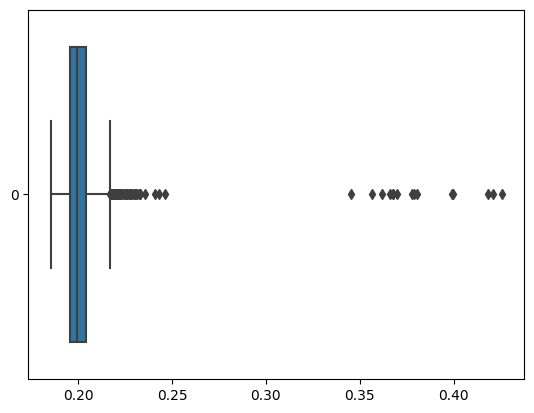

In [155]:
sns.boxplot(results, orient="h")

In [148]:
prediction_all = reg.predict(df.iloc[:, 1:])

In [151]:
mean_absolute_error(df.iloc[:, 0], prediction_all)

297.8838338807442

In [152]:
r2_score(df.iloc[:, 0], prediction_all)

0.3967383069074184